<h1 align="center">PSL Week - Topological Data Analysis</h1>
<h1 align="center">Practice 1: hands on Gudhi</h1>

In this first practice session, we will use `gudhi` to create simplicial complexes and compute their homology groups and Betti numbers. We will first start with simple and synthetic examples, and then apply computational topology on a real-world data set of images.

First load the required Python libraries. You will need `numpy`, `gudhi`, `matplotlib`, `plotly`, `networkx` and `scikit-learn`.
This practical session and the following is tailored for Python 3.10.12. Using any other version may cause some installation issues.
The fastest way to setup the environment is to use the file `requirements.txt`.
After activating your python environment, you can run
```bash
conda install --yes --file path/to/requirements.txt
```
if you use conda or
```bash
pip install path/to/requirements.txt
```
otherwise.

If any of those steps fail, you can run the following commands
```bash
conda install numpy gudhi maplotlib plotly networkx scikit-learn plotly
conda install --upgrade nbformat
```
or
```bash
pip install numpy gudhi maplotlib plotly networkx scikit-learn plotly
pip install --upgrade nbformat
```

In [97]:
import os
import itertools
import numpy as np
import gudhi as gd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.base    import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

%matplotlib inline

In [98]:
# Helper function

def create_interactive_2D_sublevelset_plot(x, y, diagram, num_levels=25):
    """
    Create an interactive plot showing sublevel sets of a 1D function with a slider.
    
    Parameters:
    -----------
    x : array-like
        x-coordinates for the function
    y : array-like  
        y-values of the function
    diagram:
        Persistence diagram data returned by gudhi
    num_levels : int, optional
        Number of levels for the slider (default: 25)
    
    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive plotly figure with slider
    """
    # Calculate bounds
    ymin, ymax = min(y) - 0.1, max(y) + 0.1

    # Extract x and y points from diagram
    points_x = [pt[1][0] for pt in diagram]
    points_y = [min(pt[1][1], ymax) for pt in diagram]
    
    # Slider values
    levels = np.linspace(ymin, ymax, num_levels)
    
    # Color palette for shaded regions
    palette = px.colors.qualitative.Plotly
    
    # -------------------------------------------------------------------
    # Helper: find connected segments where y(x) is below h
    # -------------------------------------------------------------------
    def get_segments(x, y, h):
        mask = y < h  # Changed from y > h to y < h
        segments = []

        i = 0
        n = len(x)
        while i < n:
            if mask[i]:
                start = i
                while i < n and mask[i]:
                    i += 1
                end = i
                segments.append((start, end))
            i += 1
        return segments

    # ---------------------------------------------------
    # Build the figure with two subplots
    # ---------------------------------------------------
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.6, 0.4],
        subplot_titles=("Function and sublevel sets", "Persistence Diagram")
    )

    # ---------------------------------------------------
    # Construct all traces for every slider step
    # ---------------------------------------------------
    trace_index = 0
    trace_map = []   # maps slider step → list of trace indices to show

    # Add static traces for right plot that are always visible
    # Diagonal line
    fig.add_trace(go.Scatter(
        x=[ymin, ymax],
        y=[ymin, ymax],
        mode="lines",
        line=dict(color="black", width=2),
        name="diagonal",
        visible=True
    ), row=1, col=2)
    diagonal_trace = trace_index
    trace_index += 1

    # Gray fill below diagonal
    fig.add_trace(go.Scatter(
        x=[ymin, ymax, ymax, ymin, ymin],
        y=[ymin, ymax, ymin, ymin, ymin],
        fill="toself",
        fillcolor="rgba(128, 128, 128, 0.3)",
        line=dict(width=0),
        showlegend=False,
        visible=True
    ), row=1, col=2)
    gray_fill_trace = trace_index
    trace_index += 1

    # Point cloud (static across slider steps)
    fig.add_trace(go.Scatter(
        x=points_x, y=points_y,
        mode="markers",
        marker=dict(size=7, color="red"),
        name="points",
        visible=True
    ), row=1, col=2)
    fixed_points_trace = trace_index
    trace_index += 1

    for i, h in enumerate(levels):

        # store trace ids for this slider state
        current_visible_traces = []

        # =======================
        # LEFT PLOT: main curve
        # =======================
        fig.add_trace(go.Scatter(
            x=x, y=y,
            mode="lines",
            line=dict(color="red", width=3),
            name="curve",
            visible=(i == 0)
        ), row=1, col=1)
        current_visible_traces.append(trace_index)
        trace_index += 1

        # horizontal line
        fig.add_trace(go.Scatter(
            x=x, y=np.full_like(x, h),
            mode="lines",
            line=dict(dash="dash"),
            name="h-line",
            visible=(i == 0)
        ), row=1, col=1)
        current_visible_traces.append(trace_index)
        trace_index += 1

        # shaded regions below line and above curve
        segments = get_segments(x, y, h)
        for j, (a, b) in enumerate(segments):
            seg_x = x[a:b]
            seg_y = y[a:b]

            # Fill between curve and horizontal line (below line, above curve)
            fill_x = np.concatenate([seg_x, seg_x[::-1]])
            fill_y = np.concatenate([seg_y, np.full_like(seg_x, h)[::-1]])  # Swapped order

            color = palette[j % len(palette)]

            fig.add_trace(go.Scatter(
                x=fill_x,
                y=fill_y,
                fill="toself",
                fillcolor=color.replace("1)", "0.3)") if "rgba" in color else color,
                line=dict(width=0),
                showlegend=False,
                visible=(i == 0)
            ), row=1, col=1)

            current_visible_traces.append(trace_index)
            trace_index += 1

        # =======================
        # RIGHT PLOT: crosshair lines
        # =======================

        # horizontal line
        fig.add_trace(go.Scatter(
            x=[ymin, ymax],
            y=[h, h],
            mode="lines",
            line=dict(color="red", dash="dot"),
            name="h-cross",
            visible=(i == 0)
        ), row=1, col=2)
        current_visible_traces.append(trace_index)
        trace_index += 1

        # vertical line
        fig.add_trace(go.Scatter(
            x=[h, h],
            y=[ymin, ymax],
            mode="lines",
            line=dict(color="red", dash="dot"),
            name="v-cross",
            visible=(i == 0)
        ), row=1, col=2)
        current_visible_traces.append(trace_index)
        trace_index += 1

        trace_map.append(current_visible_traces)

    # ------------------
    # Slider configuration
    # ------------------
    steps = []
    total_traces = trace_index

    for i, h in enumerate(levels):
        visible = [False] * total_traces

        # Static traces on right plot must always remain visible
        visible[diagonal_trace] = True
        visible[gray_fill_trace] = True
        visible[fixed_points_trace] = True

        # enable traces corresponding to slider i
        for idx in trace_map[i]:
            visible[idx] = True

        steps.append(dict(
            method="update",
            args=[{"visible": visible},
                {"title": f"Level y = {h:.3f}"}],
            label=f"{h:.3f}"  # Add this line to show actual y-values
        ))

    fig.update_layout(
        sliders=[dict(
            steps=steps,
            currentvalue={"prefix": "Line y = "},
            active=0  # Optional: set which step is initially active
        )],
        height=500,
        showlegend=False
    )

    fig.update_xaxes(range=[min(x), max(x)], row=1, col=1)
    fig.update_yaxes(range=[ymin - 0.5, ymax + 0.5], row=1, col=1)

    fig.update_xaxes(range=[ymin, ymax], row=1, col=2)
    fig.update_yaxes(range=[ymin, ymax], row=1, col=2)

    return fig

# A - Simplicial complexes and simplex trees

In Gudhi, (filtered) simplicial complexes are encoded through a data structure called simplex tree. Here is a very simple example illustrating the use of simplex tree to represent simplicial complexes. See the Gudhi documentation for a complete list of functionalities. Try the following code and a few other functionalities from the documentation to get used to the Simplex Tree data structure.

In [99]:
st = gd.SimplexTree() # Create an empty simplicial complex

# Simplicies can be inserted 1 by 1
# Vertices are indexed by integers
if st.insert([0,1]):
    print("First simplex inserted!")
st.insert([1,2])
st.insert([2,3])
st.insert([3,0])
st.insert([0,2])
st.insert([3,1])

First simplex inserted!


True

In [100]:
L = st.get_filtration() # Get a list with all simplices
# Notice that inserting an edge automatically inserts its vertices, if they were not already in the complex
for simplex in L:
    print(simplex)

([0], 0.0)
([1], 0.0)
([0, 1], 0.0)
([2], 0.0)
([0, 2], 0.0)
([1, 2], 0.0)
([3], 0.0)
([0, 3], 0.0)
([1, 3], 0.0)
([2, 3], 0.0)


In [101]:
# Insert the 2-skeleton, giving some filtration values to the faces
st.insert([0,1,2],filtration=0.1)
st.insert([1,2,3],filtration=0.2)
st.insert([0,2,3],filtration=0.3)
st.insert([0,1,3],filtration=0.4)

# If you add a new simplex with a given filtration value, all its faces that 
# were not in the complex are inserted with the same filtration value
st.insert([2,3,4],filtration=0.7)
L = st.get_filtration()
for simplex in L:
    print(simplex)

([0], 0.0)
([1], 0.0)
([0, 1], 0.0)
([2], 0.0)
([0, 2], 0.0)
([1, 2], 0.0)
([3], 0.0)
([0, 3], 0.0)
([1, 3], 0.0)
([2, 3], 0.0)
([0, 1, 2], 0.1)
([1, 2, 3], 0.2)
([0, 2, 3], 0.3)
([0, 1, 3], 0.4)
([4], 0.7)
([2, 4], 0.7)
([3, 4], 0.7)
([2, 3, 4], 0.7)


The filtration value of a simplex can be changed in the following way

In [102]:
st.assign_filtration((2,3,4),1.0)

L = st.get_filtration()
for simplex in L:
    print(simplex)

([0], 0.0)
([1], 0.0)
([0, 1], 0.0)
([2], 0.0)
([0, 2], 0.0)
([1, 2], 0.0)
([3], 0.0)
([0, 3], 0.0)
([1, 3], 0.0)
([2, 3], 0.0)
([0, 1, 2], 0.1)
([1, 2, 3], 0.2)
([0, 2, 3], 0.3)
([0, 1, 3], 0.4)
([4], 0.7)
([2, 4], 0.7)
([3, 4], 0.7)
([2, 3, 4], 1.0)


**Warning!** Take care that after changing the filtration value of a simplex, the result could no longer be a filtration, as illustrated below :

In [103]:
print("Giving the edge [3,4] the value 1.5:")
st.assign_filtration((3,4),1.5)
L = st.get_filtration()
for simplex in L:
    print(simplex)
print("The result is no longer a filtration : [3,4] has a higher value than its coface [2,3,4]")
print("To fix the problem, use make_filtration_non_decreasing()")
st.make_filtration_non_decreasing()
L = st.get_filtration()
for simplex in L:
    print(simplex)

Giving the edge [3,4] the value 1.5:
([0], 0.0)
([1], 0.0)
([0, 1], 0.0)
([2], 0.0)
([0, 2], 0.0)
([1, 2], 0.0)
([3], 0.0)
([0, 3], 0.0)
([1, 3], 0.0)
([2, 3], 0.0)
([0, 1, 2], 0.1)
([1, 2, 3], 0.2)
([0, 2, 3], 0.3)
([0, 1, 3], 0.4)
([4], 0.7)
([2, 4], 0.7)
([2, 3, 4], 1.0)
([3, 4], 1.5)
The result is no longer a filtration : [3,4] has a higher value than its coface [2,3,4]
To fix the problem, use make_filtration_non_decreasing()
([0], 0.0)
([1], 0.0)
([0, 1], 0.0)
([2], 0.0)
([0, 2], 0.0)
([1, 2], 0.0)
([3], 0.0)
([0, 3], 0.0)
([1, 3], 0.0)
([2, 3], 0.0)
([0, 1, 2], 0.1)
([1, 2, 3], 0.2)
([0, 2, 3], 0.3)
([0, 1, 3], 0.4)
([4], 0.7)
([2, 4], 0.7)
([3, 4], 1.5)
([2, 3, 4], 1.5)


In [104]:
# Many operations can be done on simplicial complexes, see also the Gudhi documentation and examples
print("dimension=",st.dimension())
print("filtration value of [1,2]=",st.filtration([1,2]))
print("filtration value of [4,2]=",st.filtration([4,2]))
print("num_simplices=", st.num_simplices())
print("num_vertices=", st.num_vertices())
print("skeleton[2]=", st.get_skeleton(2))
print("skeleton[1]=", st.get_skeleton(1))
print("skeleton[0]=", st.get_skeleton(0))
L = st.get_skeleton(1)
for simplex in L:
    print(simplex)

dimension= 2
filtration value of [1,2]= 0.0
filtration value of [4,2]= 0.7
num_simplices= 18
num_vertices= 5
skeleton[2]= <_cython_3_0_11.generator object at 0x70b020d5b600>
skeleton[1]= <_cython_3_0_11.generator object at 0x70b020d5b600>
skeleton[0]= <_cython_3_0_11.generator object at 0x70b020d5b600>
([0, 1], 0.0)
([0, 2], 0.0)
([0, 3], 0.0)
([0], 0.0)
([1, 2], 0.0)
([1, 3], 0.0)
([1], 0.0)
([2, 3], 0.0)
([2, 4], 0.7)
([2], 0.0)
([3, 4], 1.5)
([3], 0.0)
([4], 0.7)


## Exercise 1. 
Manipulate the simplex tree functions ( https://gudhi.inria.fr/python/latest/simplex_tree_ref.html ) for the given simplicial complex below

<p align="center">
    <img src="simplicial_complex.png" alt="PSL Week" width="200" />
</p>

In [105]:
# 1. Create the simplex tree associated to the figure above and assign a value of 1 to all simplices. Print the simplices.
st = gd.SimplexTree()
st.insert([1, 2, 4], filtration=1.0)
st.insert([2, 3, 5], filtration=1.0)
st.insert([4, 5, 6], filtration=1.0)
for simplex in st.get_simplices():
    print(simplex)

([1, 2, 4], 1.0)
([1, 2], 1.0)
([1, 4], 1.0)
([1], 1.0)
([2, 3, 5], 1.0)
([2, 3], 1.0)
([2, 4], 1.0)
([2, 5], 1.0)
([2], 1.0)
([3, 5], 1.0)
([3], 1.0)
([4, 5, 6], 1.0)
([4, 5], 1.0)
([4, 6], 1.0)
([4], 1.0)
([5, 6], 1.0)
([5], 1.0)
([6], 1.0)


In [106]:
# 2. Now assign the value 0 to the triangle t_1 and 0.5 to the traingle t_2, and print again the simplices. Is it a valid filtration?
st.assign_filtration([1, 2, 4], filtration=0.0)
st.assign_filtration([2, 3, 5], filtration=0.5)
for simplex in st.get_simplices():
    print(simplex)

([1, 2, 4], 0.0)
([1, 2], 1.0)
([1, 4], 1.0)
([1], 1.0)
([2, 3, 5], 0.5)
([2, 3], 1.0)
([2, 4], 1.0)
([2, 5], 1.0)
([2], 1.0)
([3, 5], 1.0)
([3], 1.0)
([4, 5, 6], 1.0)
([4, 5], 1.0)
([4, 6], 1.0)
([4], 1.0)
([5, 6], 1.0)
([5], 1.0)
([6], 1.0)


In [107]:
# 3. Fix the simplex tree so that the filtration is valid, and print the simplices.
st.assign_filtration([1, 2], filtration=0.0)
st.assign_filtration([2, 4], filtration=0.0)
st.assign_filtration([1, 4], filtration=0.0)
st.assign_filtration([4], filtration=0.0)
st.assign_filtration([2], filtration=0.0)
st.assign_filtration([1], filtration=0.0)
st.assign_filtration([2, 3], filtration=0.5)
st.assign_filtration([2, 5], filtration=0.5)
st.assign_filtration([3, 5], filtration=0.5)
st.assign_filtration([5], filtration=0.5)
st.assign_filtration([3], filtration=0.5)
for simplex in st.get_simplices():
    print(simplex)

([1, 2, 4], 0.0)
([1, 2], 0.0)
([1, 4], 0.0)
([1], 0.0)
([2, 3, 5], 0.5)
([2, 3], 0.5)
([2, 4], 0.0)
([2, 5], 0.5)
([2], 0.0)
([3, 5], 0.5)
([3], 0.5)
([4, 5, 6], 1.0)
([4, 5], 1.0)
([4, 6], 1.0)
([4], 0.0)
([5, 6], 1.0)
([5], 0.5)
([6], 1.0)


In [108]:
# 4. Rebuild a new simplex tree for the same simplicial complex by directly assigning the filtration values 1 for t_3, 0.5 for t_2, and 0 for t_1.
# Verify that the previous simplex tree is identical to the new one.
st_2 = gd.SimplexTree()
st_2.insert([1, 2, 4], filtration=0.0)
st_2.insert([2, 3, 5], filtration=0.5)
st_2.insert([4, 5, 6], filtration=1.0)

for simplex in st_2.get_simplices():
    print(simplex)

([1, 2, 4], 0.0)
([1, 2], 0.0)
([1, 4], 0.0)
([1], 0.0)
([2, 3, 5], 0.5)
([2, 3], 0.5)
([2, 4], 0.0)
([2, 5], 0.5)
([2], 0.0)
([3, 5], 0.5)
([3], 0.5)
([4, 5, 6], 1.0)
([4, 5], 1.0)
([4, 6], 1.0)
([4], 0.0)
([5, 6], 1.0)
([5], 0.5)
([6], 1.0)


# B - Filtrations, persistence and Betti numbers computation

In [109]:
# As an example, we assign to each simplex its dimension as filtration value
for splx in st.get_filtration():
    st.assign_filtration(splx[0],len(splx[0])-1)
L = st.get_filtration()
for simplex in L:
    print(simplex)

([1], 0.0)
([2], 0.0)
([3], 0.0)
([4], 0.0)
([5], 0.0)
([6], 0.0)
([1, 2], 1.0)
([2, 3], 1.0)
([1, 4], 1.0)
([2, 4], 1.0)
([2, 5], 1.0)
([3, 5], 1.0)
([4, 5], 1.0)
([4, 6], 1.0)
([5, 6], 1.0)
([1, 2, 4], 2.0)
([2, 3, 5], 2.0)
([4, 5, 6], 2.0)


Before computing Betti numbers, we first need to compute persistence of the filtration. 

In [110]:
# To compute the persistence diagram of the filtered complex
# By default it stops at dimension-1, use persistence_dim_max=True
# to compute homology in all dimensions
## Here, for the moment, we use it as a preprocessing step to compute Betti numbers. 
diag = st.persistence(persistence_dim_max=True)
# Display each interval as (dimension, (birth, death))
print(diag)

[(1, (1.0, inf)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (1, (1.0, 2.0)), (0, (0.0, inf)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0)), (0, (0.0, 1.0))]


In [111]:
print(st.betti_numbers())

[1, 1, 0]


## Exercise 2. 

In [112]:
# 1. Show the betti numbers of the filtration of the exercice 1.1
diag = st.compute_persistence()
print(st.betti_numbers())

[1, 1]


In [113]:
# 2. Show the betti numbers of the filtration of the exercice 1.4
diag_2 = st_2.compute_persistence()
print(st_2.betti_numbers())

[1, 1]


In [114]:
# 3. Create a new simplex tree by assigning arbitrary filtration values to each one of the triangles and show the betti numbers.
# Does the filtration affect the betti numbers?
st_3 = gd.SimplexTree()
st_3.insert([1, 2, 4], filtration=0.2)
st_3.insert([2, 3, 5], filtration=0.7)
st_3.insert([4, 5, 6], filtration=0.9)

diag_3 = st_3.compute_persistence()
print(st_3.betti_numbers())

[1, 1]


## Persistence for functions defined over a grid
When a function is defined over a grid on $[0,1]$, $[0,1]^2$, ... the grid can be directly used to build the filtration using a cubical complex as illustrated in the following examples. 

### Persistence of 1D function

Let consider $f: t \mapsto sin(2t)+sin(3t)$ defined over $[0, 2\pi]$. 

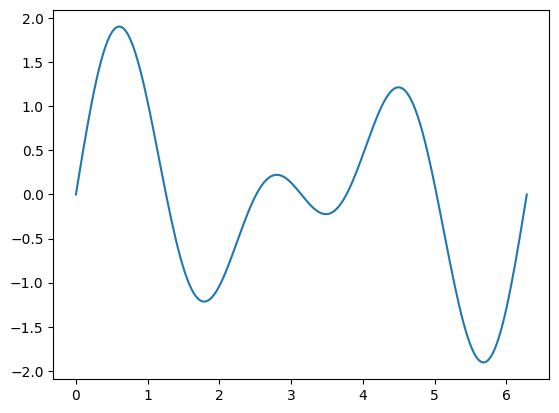

In [115]:
# 1. Build a table with 200 values of f between 0 and 2*pi and plot the function using matplotlib

t = np.linspace(0, 2*np.pi, 200)
f = np.sin(2*t) + np.sin(3*t)
plt.figure()
plt.plot(t,f)
plt.show()

[(0, (-1.9058824372379726, inf)), (0, (-1.2153170217209184, 1.2153170217209182)), (0, (0.0, 1.9058824372379726)), (0, (-0.223003995329198, 0.22300399532919868))]


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

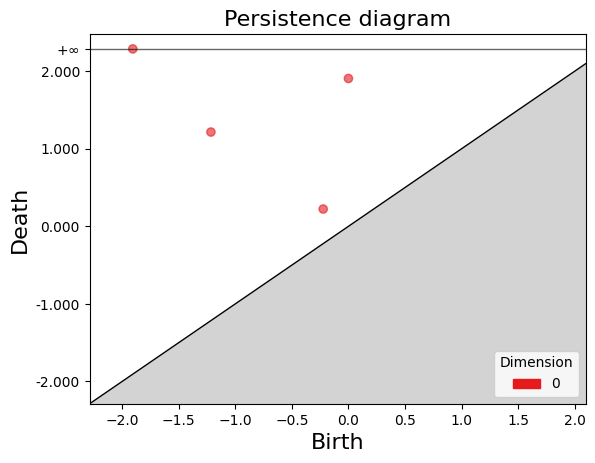

In [116]:
# 2. Compute the persistence diagram of its sublevelsets, and draw its persistence diagram.

cplx = gd.CubicalComplex(top_dimensional_cells=f)
dgm = cplx.persistence()
print(dgm)
gd.plot_persistence_diagram(dgm)

In [117]:
# 3. To get a better understanding of the sublevelset filtration and its persistence diagram, run the code below and play with the slider.
# How can you retrieve the 0th betti number at a given filtration value?

create_interactive_2D_sublevelset_plot(t, f, dgm, 50)

In [118]:
# 4. Add some noise to f, recompute the diagram and visualize again the interactive plot. Observe how the diagram changes as you increase the noise level
# Can you still recognize the main features?

noise = np.random.randn(*f.shape) * 0.5
cplx = gd.CubicalComplex(top_dimensional_cells=f + noise)
dgm = cplx.persistence()
create_interactive_2D_sublevelset_plot(t, f + noise, dgm, 50)

##### Remark:
The name top_dimensional_cells is because gudhi gives the grid values to top-dimensional cells and deduces values for other cells, instead of giving values to vertices and deducing values for other cells. 

### Persistence of 2D function

Let $p_0=(0.25, 0.25), p_1=(0.75, 0.75), p_2 = (0.0, 1.0)$ and $p_3 = (1.0, 0.0)$ be 4 points in the plane $\mathbb{R}^2$ and $\sigma=0.05$.
Define the function $f$ as
$$f(p)=\exp(-\frac{\|p-p_0\|^2}{\sigma})+3\exp(-\frac{\|p-p_1\|^2}{\sigma}) - 4*\exp(-\frac{\|p-p_2\|^2}{\sigma}) 
- 2 \exp(-\frac{\|p-p_3\|^2}{\sigma})$$ 

In [119]:
# 1. Implement the function f as a function of x and y

def f(x,y):
    sigma=0.05
    T0 = np.exp(-(np.square(x-0.25)+np.square(y-0.25))/sigma)
    T1 = np.exp(-(np.square(x-0.75)+np.square(y-0.75))/sigma)
    T2 = np.exp(-(np.square(x-0.0)+np.square(y-1.0))/sigma)
    T3 = np.exp(-(np.square(x-1.0)+np.square(y-0.0))/sigma)
    return T0 + 3*T1 - 4*T2 - 2*T3

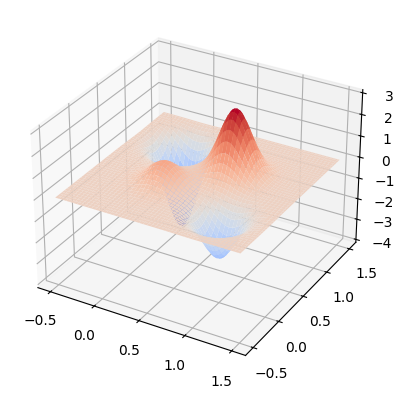

In [120]:
# 2. Compute the values of f on a grid [-0.5,1.5] x [-0.5,1.5] with 100 points in each direction and plot it using matplotlib.

grid = np.linspace(-0.5,1.5,100)
gridx = grid[:,np.newaxis]
gridy = grid[np.newaxis,:]
mountains = f(gridx,gridy)
#sq = - gridx**2 - gridy**2
#volcano = np.exp(sq) - 0.7 * np.exp(sq*4)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(gridx, gridy, mountains, cmap=matplotlib.cm.coolwarm)

### Exercise 3
Compute the persistence diagram of the sublevel set filtration of $f$ and compute the persistence diagram of the upperlevel set filtration of $f$ and compare the obtained diagram to the previous one. 

[(1, (3.885444089439261e-05, 2.9992546439129733)), (1, (0.2739833550556788, 0.9998467861103956)), (0, (-3.9959026399382815, inf)), (0, (-1.9979422073731024, 1.2843163224654793e-05)), (0, (5.075693767833819e-10, 3.869196528349165e-05)), (0, (1.691897922603558e-10, 1.2698156375961765e-05))]


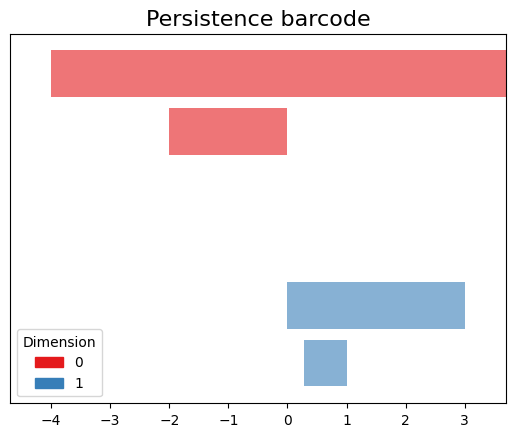

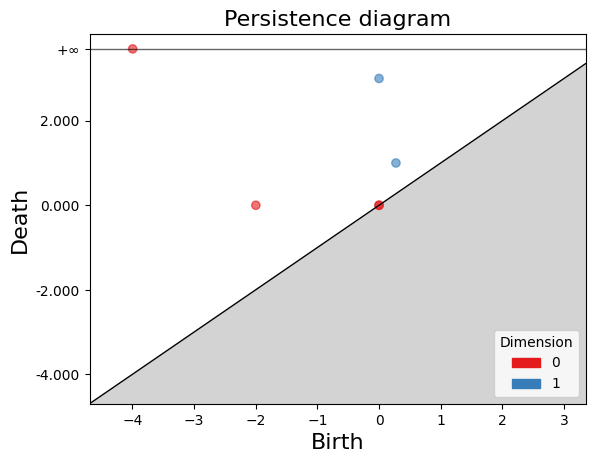

In [121]:
# 1. Build the sublevelset filtration of the function above and show its persistence barcode and persistence diagram.

cplx = gd.CubicalComplex(top_dimensional_cells=mountains)
diag = cplx.persistence()
gd.plot_persistence_barcode(diag, legend=True)
gd.plot_persistence_diagram(diag, legend=True)
# red is dimension 0, blue is dimension 1

print(diag)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

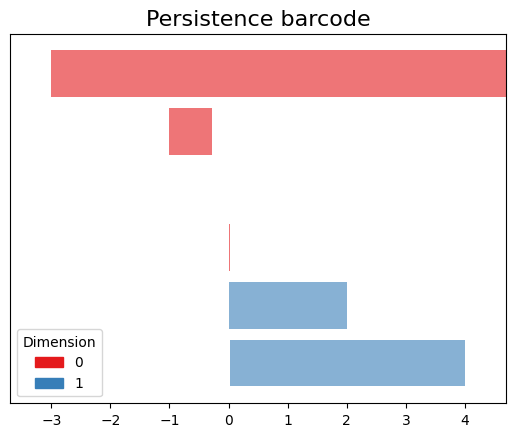

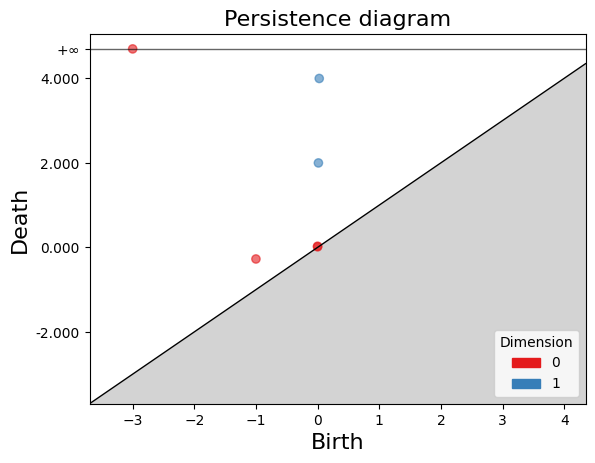

In [122]:
# 2. Do the same but for -f this time
cplx = gd.CubicalComplex(top_dimensional_cells=-mountains)
diag = cplx.persistence()

gd.plot_persistence_barcode(diag, legend=True)
gd.plot_persistence_diagram(diag, legend=True)  

## Persistence over a filtered simplicial complex and Betti number. 

In [123]:
# 1. Recall the torus is homeomorphic to the surface obtained by identifying the opposite sides of a square.
# Using Gudhi, construct a triangulation (2-dimensional simplicial complex) of the Torus. Define a filtration on it, compute its persistence and use it to deduce the Betti numbers of the torus.

#Computation of the Betti numbers of the 2-dimensional torus
st = gd.SimplexTree()

T = ([0,1,4],[1,2,5],[2,0,3],[0,3,4],[1,4,5],[2,5,3],[3,4,7],[4,5,8],[5,3,6],[3,6,7],[4,7,8],[5,8,6],[6,7,1],[7,8,2],[8,6,0],\
    [6,0,1],[7,1,2],[8,2,0])

for t in T:
    st.insert(t)

st.compute_persistence(persistence_dim_max=True)
print(st.betti_numbers())

[1, 2, 1]


In [124]:
# 2. Use Gudhi to compute the Betti numbers of a sphere of dimension 2 and of a sphere of dimension 3
# (hint: the k -dimensional sphere is homeomorphic to the boundary of a (k+1)-dimensional simplex.

#computation of the betti numbers of the n-dimensional sphere
n=10
st = gd.SimplexTree()
simplex = []
#insert the (n+1)-dimensional simplex in st. All its faces are automatically added. 
for i in range(n+2):
    simplex.append(i)
st.insert(simplex)
#remove the (n+1)-dimensional simplex. Its faces remains in the simplicial complex to get a n-dimensional sphere.
st.remove_maximal_simplex(simplex)
st.set_dimension(n+1)  ## To get the betti number in dimension n! 
st.compute_persistence()
print(st.betti_numbers())

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


# Vietoris-Rips and alpha-complex filtrations

For the definition of Vietoris-Rips and $\alpha$-complexes, see the slides of the course: https://geometrica.saclay.inria.fr/team/Fred.Chazal/slides/Persistence2022.pdf

See also the following book, p.137
https://hal.inria.fr/hal-01615863v2/document

Take care that in GUDHI the α-complex filtration is indexed by the square of the radius of the smallest empty circumscribing ball. 

These are basic instructions to build Vietoris-Rips and α-complex filtrations (and compute their persistent homology).

##### Random point cloud

In [125]:
# 1. Create a random point cloud in 3D

nb_pts=100
pt_cloud = np.random.rand(nb_pts,3)

Number of simplices in the V-R complex:  41183
142


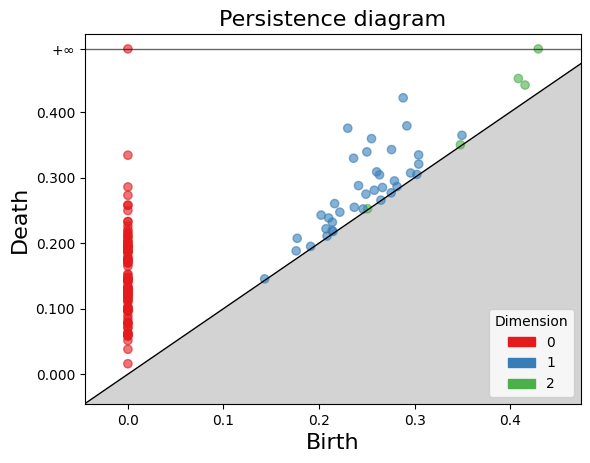

In [126]:
# 2. Build Rips-Vietoris filtration from the point cloud and compute its persistence diagram (see https://gudhi.inria.fr/python/latest/rips_complex_user.html#example-from-a-point-cloud)

rips_complex = gd.RipsComplex(points=pt_cloud,max_edge_length=0.5)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
print("Number of simplices in the V-R complex: ",simplex_tree.num_simplices())
dgm = simplex_tree.persistence(homology_coeff_field=2, min_persistence=0)
gd.plot_persistence_diagram(dgm)
print(len(dgm))

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

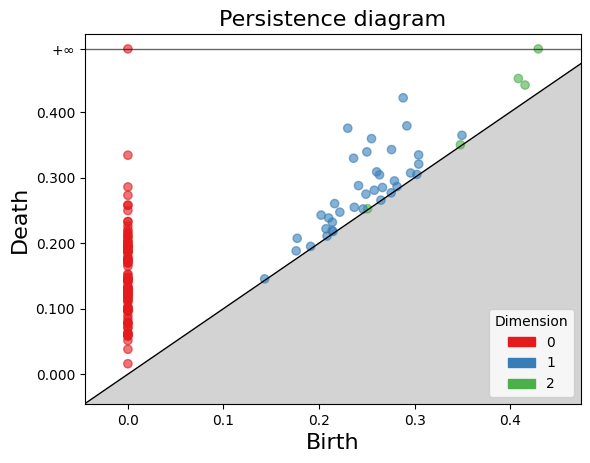

In [127]:
# 3. Compute Rips-Vietoris filtration and compute its persistence diagram from a pairwise distance matrix (see https://gudhi.inria.fr/python/latest/rips_complex_user.html#distance-matrix)
dist_mat = []
for i in range(nb_pts):
    ld = []
    for j in range(i):
        ld.append(np.linalg.norm(pt_cloud[i,:]-pt_cloud[j,:]))
    dist_mat.append(ld)
rips_complex2 = gd.RipsComplex(distance_matrix=dist_mat,max_edge_length=0.5)
simplex_tree2 = rips_complex2.create_simplex_tree(max_dimension=3)
diag2 = simplex_tree2.persistence(homology_coeff_field=2, min_persistence=0)
gd.plot_persistence_diagram(diag2)

Number of simplices in the alpha-complex:  2329


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

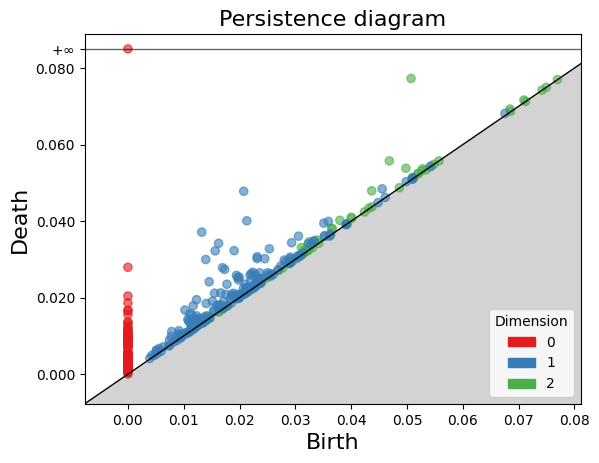

In [128]:
# 4. Compute the alpha-complex filtration and compute its persistence (see https://gudhi.inria.fr/python/latest/delaunay_complex_ref.html#alpha-complex-reference-manual)

alpha_complex = gd.AlphaComplex(points=pt_cloud)
simplex_tree3 = alpha_complex.create_simplex_tree()
print("Number of simplices in the alpha-complex: ",simplex_tree3.num_simplices())
diag3 = simplex_tree3.persistence(homology_coeff_field=2, min_persistence=0)
gd.plot_persistence_diagram(diag3)

#### Sampled torus in $\mathbb{R}^4$

Consider the paramatrized torus in $\mathbb{R}^4$:

$$(s,t) \to (\cos(s),\sin(s),\cos(t),\sin(t)), \ \  \ (s,t) \in [0,2\pi] \times [0,2\pi]$$


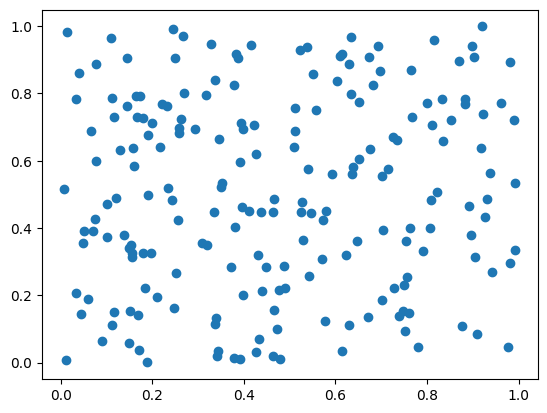

In [129]:
# 1. Randomly sample n points (try different values of n) on the parametrized torus defined above and show the first two coordinates of all the points on the plane.

nb_pts=200
pt_cloud = np.random.rand(nb_pts,2)

b = np.stack((np.cos(2*np.pi*pt_cloud[:,0]),np.sin(2*np.pi*pt_cloud[:,0]),np.cos(2*np.pi*pt_cloud[:,1]),\
              np.sin(2*np.pi*pt_cloud[:,1])),axis=-1)
# Plot the points on the unwrapped torus
plt.figure()
plt.scatter(pt_cloud[:,0],pt_cloud[:,1])
plt.show()

[(3, (1.0241187174939497, 2.000000000081441)), (2, (0.4014771704795437, 1.0187507043867252)), (1, (0.06304161688849041, 1.000039092475077)), (1, (0.06668540973420892, 1.0000078516234097)), (1, (0.0706476082800227, 0.291883053448698)), (1, (0.0788503679617833, 0.2961915835202601)), (1, (0.06925693360861035, 0.2864319782908251)), (1, (0.08071039167842477, 0.2861089544084818)), (1, (0.06523842759175177, 0.26984128408587205)), (1, (0.08529863923692818, 0.2849457943315882)), (1, (0.08228535701417591, 0.2588888357414335)), (1, (0.09168515357141388, 0.2606451284261441)), (1, (0.09851237915858421, 0.26349180550266915)), (1, (0.10304158103859135, 0.2633264828989038)), (1, (0.10962755105579851, 0.22249837675813244)), (1, (0.07433205226622952, 0.18383423817819974)), (1, (0.10332544919751109, 0.21072721522285146)), (1, (0.0934645984905203, 0.2004131202305302)), (1, (0.07067840127362605, 0.17313166061921104)), (0, (0.0, inf))]


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

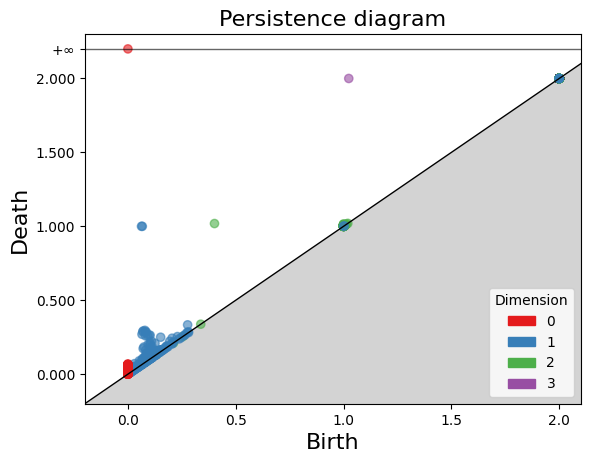

In [130]:
# 2. Compute the persistence diagrams of the resulting alpha-complex filtration. 

cplx = gd.AlphaComplex(points=b).create_simplex_tree()
p = cplx.persistence()
# print only the most persistent features
print([(dim,(birth,death)) for (dim,(birth,death)) in p if death - birth > .1])
gd.plot_persistence_diagram(p, legend=True)

[(1, (0.5021617941997994, 1.7536079423878228)), (1, (0.5164703659812785, 1.746906693381463)), (1, (0.526334242126086, 1.0604819762805264)), (1, (0.5108362852881607, 1.0189718918098714)), (1, (0.5616061536763403, 1.0587304164679097)), (1, (0.5681914877166843, 1.04694401966227)), (1, (0.5315923561528051, 0.9876128196116017)), (1, (0.5841186154778092, 1.012565785823696)), (1, (0.5737084870007623, 0.9921707839103986)), (1, (0.6055911279779911, 0.9796577517083663)), (1, (0.6277336350987869, 0.9873155349196012)), (1, (0.6420018100865179, 0.996817478062636)), (1, (0.5452781024990075, 0.825335430660464)), (1, (0.6428855238610094, 0.9175208277823335)), (1, (0.6622010300680556, 0.9237773441808189)), (1, (0.531708195436655, 0.7878336198807915)), (1, (0.6114396077799353, 0.8431477328474783)), (1, (0.5725825147801342, 0.7830160217630832)), (1, (0.70882027296804, 0.9031068694579718)), (1, (0.5894018063237908, 0.7491990936819662)), (1, (0.6420766350667094, 0.8012155919575962)), (1, (0.351248692940636

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

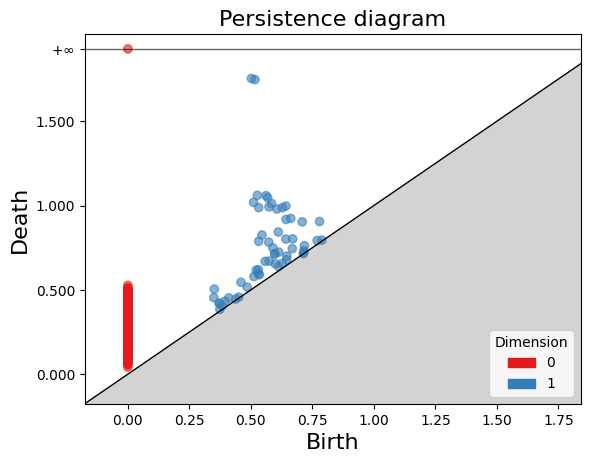

In [131]:
# 3. Do the same with the Vietoris-Rips complex up to dimension 2.
# What do you observe?

cplx = gd.RipsComplex(points=b).create_simplex_tree(max_dimension=2)
p = cplx.persistence()
# print only the most persistent features
print([(dim,(birth,death)) for (dim,(birth,death)) in p if death - birth > .1])
gd.plot_persistence_diagram(p, legend=True)

Now, consider a 1D line embedded in the torus according to the following parametrization:

$$t \to (\cos(t),\sin(t),\cos(5t),\sin(5t)), \ \  \ t \in [0,2\pi] $$

and do the same experiment as previously. What do you observe? Explain it. 

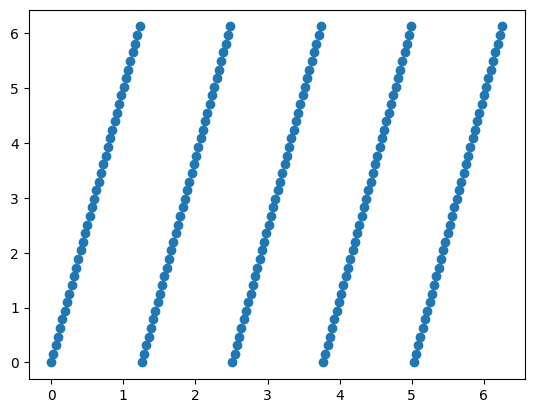

In [132]:
# 1. Sample the points evenly along the parametrization above

a = np.linspace(0, 2*np.pi, 200, False)
b = np.stack((np.cos(2*np.pi*a),np.sin(2*np.pi*a),np.cos(2*np.pi*5*a),np.sin(2*np.pi*5*a)),axis=-1)
# Plot the points on the unwrapped torus
plt.figure()
plt.scatter(a, 5*a % (2*np.pi))
plt.show()

[(3, (1.0993408779236802, 2.000000000050757)), (2, (0.34306079583226234, 1.0023110448779162)), (1, (0.007218296684657493, 1.099114145781098)), (1, (0.3365431168536974, 1.0017027473365379)), (0, (0.0, inf))]


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

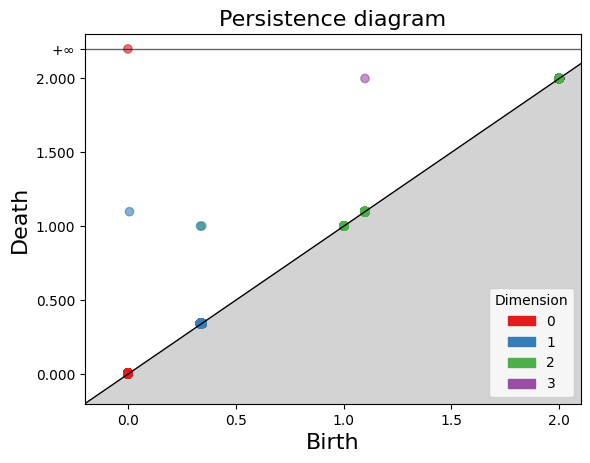

In [133]:
# 2. Compute the alpha complex of the points and show the persistence diagram
# What do you observe ?

cplx = gd.AlphaComplex(points=b).create_simplex_tree()
p = cplx.persistence()
# print only the most persistent features
print([(dim,(birth,death)) for (dim,(birth,death)) in p if death - birth > .1])
gd.plot_persistence_diagram(p, legend=True)

## Exercise 4.

(np.float64(-1.0992239638099202),
 np.float64(1.1003800177366854),
 np.float64(-1.0996368991221117),
 np.float64(1.0999670824244938))

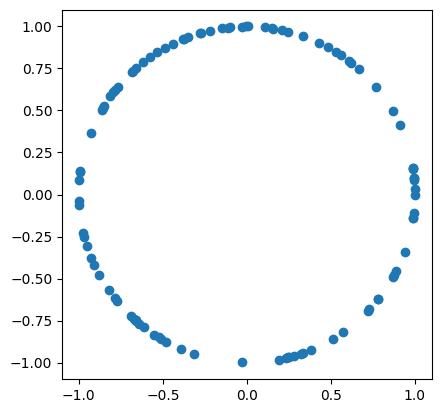

In [134]:
# 1. Randomly sample n = 100 points on the unit circle in the Euclidean plane.

nb_pts=100
angles = np.random.rand(nb_pts,1)
pt_cloud = np.concatenate([np.cos(2*np.pi*angles),np.sin(2*np.pi*angles)],axis=1)

plt.scatter(pt_cloud[:,0],pt_cloud[:,1])
plt.axis('square')

In [135]:
# 2. For R in np.arange(0.0,0.5,0.01), compute the Betti numbers of the subcomplex of the Rips-Vietoris filtration (up to dimension 2) made
# of the simplices with index value at most R and plot the curve giving the Betti numbers as functions of R.
# These curves are called the Betti curves of the filtration.

betti0 = []
betti1 = []
for R in np.arange(0.01,0.5,0.01):
    rips_complex = gd.RipsComplex(points=pt_cloud,max_edge_length=R)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    simplex_tree.compute_persistence()
    betti0.append(simplex_tree.betti_numbers()[0])
    betti1.append(simplex_tree.betti_numbers()[1])
    
param = np.arange(0.01,0.5,0.01)

plt.figure()
plt.plot(param,betti0,color='red')
plt.plot(param,betti1,color='blue')
plt.show()

IndexError: list index out of range

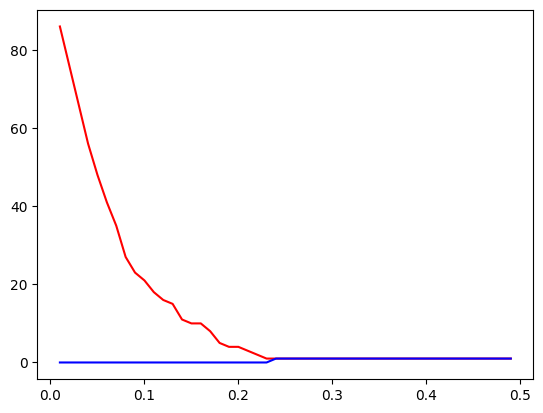

In [ ]:
# 3. Can we get the same curves directly from the persistence diagram of the Rips-Vietoris filtration (you will have to guess what the persistence diagrams represent)?
# If so, compute them using the persistence diagram.

rips_complex = gd.RipsComplex(points=pt_cloud,max_edge_length=0.5)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
simplex_tree.compute_persistence()
intervals0 = simplex_tree.persistence_intervals_in_dimension(0)
intervals1 = simplex_tree.persistence_intervals_in_dimension(1)

betti0 = []
betti1 = []
for R in np.arange(0.01,0.5,0.01):
    betti0.append(np.sum(intervals0[:,1] > R))
    betti1.append(np.sum((intervals1[:,0] <= R) & (intervals1[:,1] > R)))
    
param = np.arange(0.01,0.5,0.01)

plt.figure()
plt.plot(param,betti0,color='red')
plt.plot(param,betti1,color='blue')
plt.show()

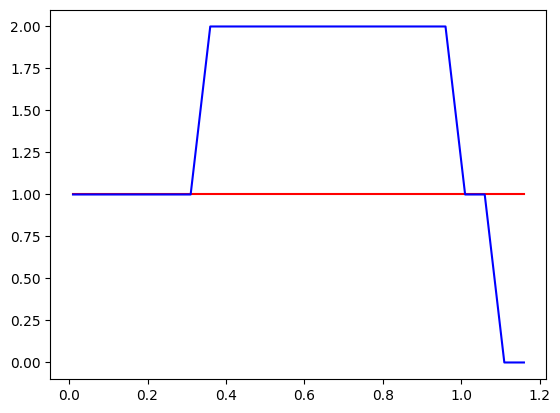

In [ ]:
# 4. Do the same for the point cloud sampled on the torus in R^4 in the above exercise. 

cplx = gd.AlphaComplex(points=b).create_simplex_tree()
p = cplx.persistence()
intervals0 = cplx.persistence_intervals_in_dimension(0)
intervals1 = cplx.persistence_intervals_in_dimension(1)

betti0 = []
betti1 = []
for R in np.arange(0.01,1.2,0.05):
    betti0.append(np.sum(intervals0[:,1] > R))
    betti1.append(np.sum((intervals1[:,0] <= R) & (intervals1[:,1] > R)))
    
param = np.arange(0.01,1.2,0.05)

plt.figure()
plt.plot(param,betti0,color='red')
plt.plot(param,betti1,color='blue')
plt.show()

# C - (BONUS) Application to COIL data set

The goal of this second exercise is to visualize and classify a data set using simplicial complexes and Betti numbers. The data set is the Columbia Object Image Library, which is made of gray scale images of rotating objects.

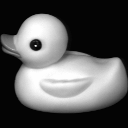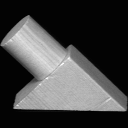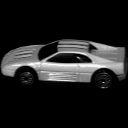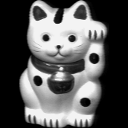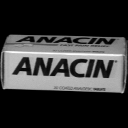

You can download the data [here](https://www.math.ens.psl.eu/~eaamari/teaching/2025-2026/PSL_Week/coil-20-proc.zip). Set up the `path` variable to where the data is in your machine.

In [ ]:
path = './coil-20-proc/'

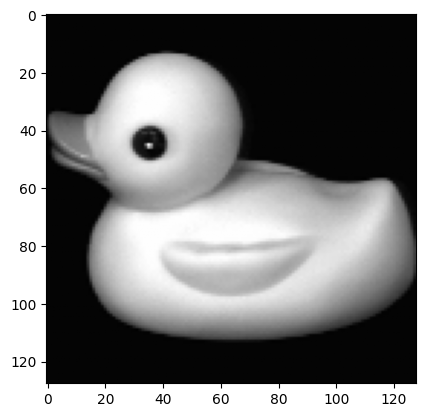

In [ ]:
plt.figure()
plt.imshow(plt.imread(path + 'obj1__0.png'), cmap='gray')
plt.show()

Read the images and their labels (the object they represent) in `numpy` arrays.

In [ ]:
images, labels = [], []
for img in os.listdir(path):
    images.append( np.array(plt.imread(path + img)).flatten() )
    labels.append(img.split('_')[0])
labels = np.array(labels)
images = np.vstack([img[None,:] for img in images])

For an object of your choice, compute the plot the first two principal components of the dataset composed of all of its views. What do you see?

In [ ]:
## TO DO

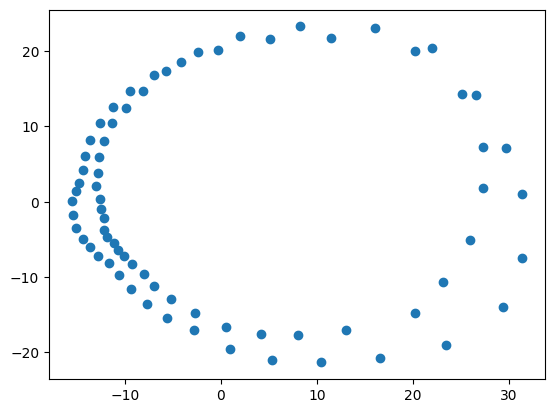

In [ ]:
## Solution 
indices = np.argwhere(labels == 'obj5').ravel()
pca = PCA(n_components=2).fit_transform(images[indices])
plt.figure()
plt.scatter(pca[:,0],pca[:,1])
plt.show()

We are now going to classify images based on their Betti numbers. First, write a function that turns images into simplicial complexes, by triangulating every pixel with two triangles, and leaving aside pixels whose gray scale value is below a pre-defined threshold. Test your function on an image, compute the Betti numbers of its associated complex, and visualize the filtered image to check that the Betti numbers make sense.

In [ ]:
def image_to_simplex_tree(image, threshold):
    num_rows, num_cols = image.shape[0], image.shape[1]
    st = gd.SimplexTree()
    for i in range(0,num_rows):
        for j in range(0,num_cols):
            if image[i,j] >= threshold:
                st.insert([num_rows*i+j,   num_rows*i+j+1,     num_rows*(i+1)+j])
                st.insert([num_rows*i+j+1, num_rows*(i+1)+j+1, num_rows*(i+1)+j])
    return st

def Betti_numbers(simplex_tree):
    diag = simplex_tree.compute_persistence()
    return simplex_tree.betti_numbers()

In [ ]:
I = plt.imread(path + 'obj1__0.png')

In [ ]:
st = image_to_simplex_tree(I, 0.1)

In [ ]:
Betti_numbers(st)

[1, 2]

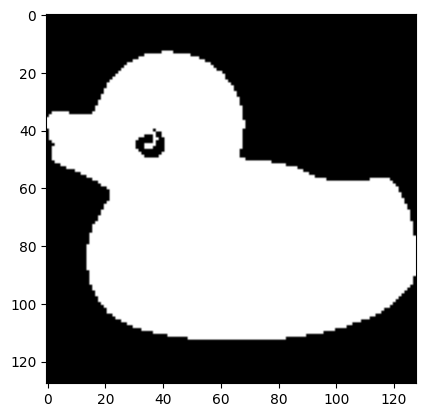

In [ ]:
plt.figure()
plt.imshow(I>=0.1, cmap='gray')
plt.show()

Compute the Betti numbers of the complexes computed with a given threshold on the images associated to a few objects. Then, use these features to train classifiers (such as SVM or random forests) and compute their accuracies on random 80%/20% train/test splits of the data.

In [ ]:
threshold = 0.1
topological_features = np.vstack([
    np.array(Betti_numbers(image_to_simplex_tree(
        np.reshape(I,[int(np.sqrt(len(I))),int(np.sqrt(len(I)))]), threshold)))[None,:2] for I in images
])

In [ ]:
indices              = np.argwhere((labels == 'obj1')|(labels == 'obj2')|(labels == 'obj3')|(labels == 'obj4')).ravel()
test_size            = 0.2
perm                 = np.random.permutation(len(indices))
limit                = int(test_size * len(indices))
test_sub, train_sub  = perm[:limit], perm[limit:]
train_labs           = labels[indices[train_sub]]
test_labs            = labels[indices[test_sub]]

In [ ]:
train_betti = topological_features[indices[train_sub]]
test_betti  = topological_features[indices[test_sub]]

In [ ]:
rf = RandomForestClassifier().fit(train_betti, train_labs)
acc = rf.score(test_betti, test_labs)

In [ ]:
print(acc)

0.8421052631578947


In [ ]:
svm = SVC().fit(train_betti, train_labs)
acc = svm.score(test_betti, test_labs)

In [ ]:
print(acc)

0.8070175438596491


Since Betti numbers are ordinal data, check the effect of one-hot encoding on the accuracies.

In [ ]:
topological_features_ohe = OneHotEncoder().fit_transform(topological_features)
train_betti     = topological_features_ohe[indices[train_sub]]
test_betti      = topological_features_ohe[indices[test_sub]]

In [ ]:
rf = RandomForestClassifier().fit(train_betti, train_labs)
acc = rf.score(test_betti, test_labs)

In [ ]:
print(acc)

0.8245614035087719


In [ ]:
svm = SVC().fit(train_betti, train_labs)
acc = svm.score(test_betti, test_labs)

In [ ]:
print(acc)

0.8596491228070176
